In [59]:
import pandas as pd
import numpy as np
import operator

## Loads in the different .feather datasets


In [60]:
anp_df = pd.read_feather('data/anp.feather')
image_d_df = pd.read_feather('data/image_data.feather')
image_m_df = pd.read_feather('data/image_metrics.feather')
face_df = pd.read_feather('data/face.feather')
object_df = pd.read_feather('data/object_labels.feather')

In [61]:
image_d_df = pd.read_feather('data/image_data.feather')
survey_df = pd.read_feather('data/survey.feather')

# Adding together image data, anp, object label and face.

The next step is to create one dataframe, grouped per user, containing the aggregate data that was pulled from the users their instagram accounts. 


## anp_df

#### method:

1. the anp label is dropped because it does not make sense to aggregate this. 
2. the dataframe is then split into a sentiment dataframe and an emotion dataframe for seperate processing.

In [62]:
# drop anp_label

anp_df = anp_df.drop(['anp_label'], axis=1)

In [63]:
# make sentiment df

anp_sent = anp_df.drop(['emotion_score', 'emotion_label'], axis = 1)
anp_sent = pd.DataFrame(anp_sent.groupby(by='image_id', as_index=False)['anp_sentiment'].mean())
anp_sent = anp_sent.set_index('image_id')

In [64]:
# split for emotion

anp_emo = anp_df.drop(['anp_sentiment'], axis = 1)
len(anp_emo['image_id'].unique())

41292

In [65]:
# the emotion with the highest score is taken for each user

ax = anp_emo.groupby(['image_id'])['emotion_score'].transform(max) == anp_emo['emotion_score']
anp_emo = anp_emo[ax]

In [66]:
# duplicates are removed to get only unique images

anp_emo = anp_emo.drop_duplicates()
anp_emo = anp_emo.set_index('image_id')


In [67]:
# the emotion and sentiment dataframes are merged again.

anp_final = anp_sent.join(anp_emo)

## Image_d_df

#### method:
1. Thing that can not be aggregated such as image_link, etc, are dropped from the dataframe. 
2. Timestamp is changed so that only the hour from 00 - 23 is included.

In [68]:
# drop unnecesarry data

image_d_df = image_d_df.drop(['image_link','image_url', 'user_full_name', 'user_name'\
                              , 'user_website','user_profile_pic', 'user_bio', 'image_posted_time_unix'], axis=1)



In [69]:
# change timestamp to be 24 hours

import re

def changeTime(time):
    time = time.split()[1]
    time = time.split(':')[0]
    time = time.lstrip('0')
    time = ''.join([i for i in time if re.match('[0-9]', i) is not None])
    try: 
        return int(time)
    except:
        return 0

image_d_df['posting_time'] = image_d_df['image_posted_time'].apply(lambda x: changeTime(x))

In [70]:
# set indesx to image id and drop image_posted_time

image_d_df = image_d_df.set_index('image_id')
image_d_df = image_d_df.drop('image_posted_time', axis=1)


## object_df

#### method:
1. Only take the object with highest confidence level for each picture. 


In [71]:
# take object with max confidence

group = object_df.groupby(['image_id', 'data_amz_label'])['data_amz_label_confidence'].transform(max) == object_df['data_amz_label_confidence']
object_df = object_df[group]

## face_df: emotion

#### method:

1. first a split is made for face emotion
2. images are grouped by image_id and face_id, for each image we check have many faces how a certain emotion. The highest number of face emotions is picked as the image emotion.
3. If we have an equal number (let's say 1 joy face and one sad face, the emotion with the highest confidence level is selected. 


In [72]:
# first, split for face emotion

face_emo = face_df[['image_id', 'face_id', 'face_emo', 'emo_confidence']]
ab = face_emo.groupby(['image_id', 'face_id'])['emo_confidence'].transform(max) == face_emo['emo_confidence']
face_emo = face_emo[ab]


In [73]:

# get unique image_id's
UniqueNames = face_emo.image_id.unique()

def changeDataFrame(df):
    
    new_list = []
    
    for _id in UniqueNames:
        
        # check whether one emotion is found more often than others
        
        df_temp = face_emo.loc[face_emo['image_id'] == _id]
        counts = df_temp['face_emo'].value_counts().to_dict()
        maximum = sorted(counts.items(), key=operator.itemgetter(1))

        # if there is an equal number of emotions look at confidence.
        
        if len(maximum) > 1:
            if maximum[0][1] == maximum[1][1]:

                group = df_temp.groupby(['image_id'])['emo_confidence'].transform(max) == df_temp['emo_confidence']
                new_slice = df_temp[group]
                new_list.append([new_slice['image_id'].values[0], new_slice['face_emo'].values[0]])  
                
            else: 
                new_list.append([df_temp['image_id'].values[0], maximum[0][0]])

        # else select the emotion that is present on most faces.
        
        else: 
            new_list.append([df_temp['image_id'].values[0], maximum[0][0]])
            
    output_df = pd.DataFrame(new_list, columns=['image_id','face_emo'])
    
    return output_df
    

new_emo = changeDataFrame(face_emo)

## face_df: finding the number of faces

#### method:
1. aggregate number of faces per picture


In [74]:
# take image_id, face_id and emo_confidence

face_no_df = face_df[['image_id', 'face_id', 'emo_confidence']]
group = face_no_df.groupby(['image_id', 'face_id'])['emo_confidence'].transform(max) == face_no_df['emo_confidence']
face_no_df = face_no_df[group].drop('emo_confidence', axis=1)

In [75]:
# aggregate for number of faces 
face_count_df = pd.DataFrame(face_no_df['image_id'].value_counts())
face_count_df['no_of_faces'] = face_count_df['image_id']
face_count_df = face_count_df.drop('image_id', axis=1)


## face_df: find average age per picture

1. select face age low and high
2. take the mean value for each face
3. take the mean of those values for each picture

In [76]:
face_df_age = face_df[['image_id', 'face_age_range_low', 'face_age_range_high']]

In [77]:
# taking mean per face
face_df_age['average_age'] = (face_df_age['face_age_range_low'] + face_df_age['face_age_range_high'])/2
face_df_age

# taking mean per picture
average_age_df = pd.DataFrame(face_df_age.groupby('image_id')['average_age'].mean())

/Users/tom/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [78]:
image_d_df.head()

,image_height,image_width,image_filter,data_memorability,user_id,user_followed_by,user_follows,user_posted_photos,posting_time
image_id,,,,,,,,,
1316962883971761394_3468175004,640.0,640.0,Lo-fi,0.800521,3468175004,7.0,0.0,1.0,22
552382455733335946_263042348,612.0,612.0,Normal,0.875568,263042348,316.0,347.0,73.0,0
594552614686078174_263042348,640.0,640.0,Vesper,0.672679,263042348,316.0,347.0,73.0,4
553884883234370621_263042348,640.0,640.0,Amaro,0.843525,263042348,316.0,347.0,73.0,2
725551583154452417_263042348,640.0,640.0,Amaro,0.859796,263042348,316.0,347.0,73.0,22


# Merge different dataframes

1. join different dataframes by image_id
2. aggregate for user_id

In [79]:
# merge different dataframes
df1 = anp_final.join(image_d_df)
df2 = df1.join(face_count_df)
df3 = df2.join(average_age_df)

'''
' TODO
' Also join object dataframe and new_emo dataframe
'''

"\n' TODO\n' Also join object dataframe and new_emo dataframe\n"

In [80]:
df3.head()

,anp_sentiment,emotion_score,emotion_label,image_height,image_width,image_filter,data_memorability,user_id,user_followed_by,user_follows,user_posted_photos,posting_time,no_of_faces,average_age
1000004599066965477_545497348,0.0486,0.2296,amazement,640.0,640.0,Normal,0.873700,545497348,1345.0,498.0,505.0,14.0,NaN,NaN
1000059425592054064_703978203,-0.1062,0.3468,amazement,640.0,640.0,Normal,0.807139,703978203,687.0,376.0,2277.0,16.0,NaN,NaN
1000065308809420330_46329534,-0.0050,0.2369,amazement,640.0,640.0,Lark,0.776858,46329534,322.0,559.0,503.0,16.0,NaN,NaN
1000080765059521113_31736205,0.2522,0.3122,joy,640.0,640.0,Lark,0.856762,31736205,732.0,201.0,1052.0,17.0,NaN,NaN
1000097452173278518_206726006,-0.0246,0.5639,joy,640.0,640.0,Reyes,0.873222,206726006,1261.0,147.0,392.0,18.0,NaN,NaN


In [81]:
quant_df = df3.drop(['emotion_label', 'emotion_score', 'image_filter'], axis=1)
quant_df.head()

,anp_sentiment,image_height,image_width,data_memorability,user_id,user_followed_by,user_follows,user_posted_photos,posting_time,no_of_faces,average_age
1000004599066965477_545497348,0.0486,640.0,640.0,0.873700,545497348,1345.0,498.0,505.0,14.0,NaN,NaN
1000059425592054064_703978203,-0.1062,640.0,640.0,0.807139,703978203,687.0,376.0,2277.0,16.0,NaN,NaN
1000065308809420330_46329534,-0.0050,640.0,640.0,0.776858,46329534,322.0,559.0,503.0,16.0,NaN,NaN
1000080765059521113_31736205,0.2522,640.0,640.0,0.856762,31736205,732.0,201.0,1052.0,17.0,NaN,NaN
1000097452173278518_206726006,-0.0246,640.0,640.0,0.873222,206726006,1261.0,147.0,392.0,18.0,NaN,NaN


In [82]:
quant_df = quant_df.groupby(by='user_id').mean()
quant_df.to_csv('analysisfile.csv')
quant_df.head()

,anp_sentiment,image_height,image_width,data_memorability,user_followed_by,user_follows,user_posted_photos,posting_time,no_of_faces,average_age
user_id,,,,,,,,,,
1097967773,0.293105,636.730496,632.056738,0.843239,53.0,154.0,282.0,10.964539,1.222892,5.665663
11520833,0.069663,617.157051,617.166667,0.819178,201.0,299.0,312.0,9.669872,1.701754,26.738697
1223036636,-0.003506,640.000000,640.000000,0.869481,169.0,159.0,48.0,14.708333,1.461538,40.282051
1224423305,-0.062127,432.365854,593.170732,0.790601,1.0,18.0,41.0,14.243902,1.000000,54.000000
1249457735,0.054133,645.333333,640.000000,0.804556,66.0,93.0,30.0,13.433333,1.500000,10.835417


## Extra: try to get smile percentage per picture

In [83]:
# Takes all the face smiles where the confidence level is more than 80 percent
face_smile_df = face_df.loc[face_df['face_smile_confidence'] > 80]

# make dataframe split to include smile
face_smile_df = face_smile_df[['image_id', 'face_smile', 'face_id']]

# drop duplicate values
face_smile_df = face_smile_df.drop_duplicates()
face_smile_df = face_smile_df.drop('face_id', axis=1)

group = face_smile_df.groupby(['image_id', 'face_smile'])['face_smile'].count()
group = pd.DataFrame(group / group.groupby(level=0).sum())
# face_smile_df[group]

group.head()
# face_smile_df = group.loc[group['face_smile'] == True]
# face_smile_df


# face_smile_df = face_smile_df.groupby(by='image_id')['face_smile'].count()
# face_smile_df.head

face_smile
image_id                      face_smile            
1000126179441391393_30837828  True               1.0
1000135251972767429_31447990  True               1.0
1000159024449036821_265063047 True               1.0
1000236251867593988_22180590  False              0.5
                              True               0.5

# TOM

In [84]:
# Merge survey data with aggregated data
survey_df['insta_user_id'] = survey_df['insta_user_id'].apply(lambda x: str(int(x)))
survey_by_insta_id = survey_df.set_index('insta_user_id')
df = quant_df.join(survey_by_insta_id)

pd.set_option('display.max_columns', None)
df.head()

,anp_sentiment,image_height,image_width,data_memorability,user_followed_by,user_follows,user_posted_photos,posting_time,no_of_faces,average_age,id,gender,born,education,employed,income,A_2,N_1,P_1,E_1,A_1,H_1,M_1,R_1,M_2,E_2,LON,H_2,P_2,N_2,A_3,N_3,E_3,H_3,R_2,M_3,R_3,P_3,HAP,participate,completed,start_q,end_q,network_id,P,E,R,M,A,PERMA,N_EMO,P_EMO,imagecount,private_account
1097967773,0.293105,636.730496,632.056738,0.843239,53.0,154.0,282.0,10.964539,1.222892,5.665663,eaedd77da06ceba5d3b375c234ab3bda,Male,1991,College graduate,Employed for wages,"$40,000 to $49,999",5,7,6,6,4,5,8,6,6,4,5,7,4,5,5,6,4,7,5,5,6,4,5.0,Yes,true,2016-12-05 16:39:02,2016-12-05 16:40:22,044b69383c,6,6.0,6.0,8.0,4.0,6,7.0,6,282.0,public
11520833,0.069663,617.157051,617.166667,0.819178,201.0,299.0,312.0,9.669872,1.701754,26.738697,2c3579cbf6ddc98313910d9d7fabb70c,Female,1978,High school graduate,A homemaker,"$90,000 to $99,999",7,3,7,8,8,6,7,10,8,7,4,7,8,2,9,3,6,7,8,6,7,9,8.0,Yes,true,2016-12-05 14:08:47,2016-12-05 14:10:57,89140f0f7a,7,8.0,10.0,7.0,8.0,7,3.0,7,312.0,public
1223036636,-0.003506,640.000000,640.000000,0.869481,169.0,159.0,48.0,14.708333,1.461538,40.282051,bd358b80f59b6d0c7f5692b204a38525,Female,1984,College graduate,Employed for wages,"$100,000 to $149,999",5,4,8,9,10,8,10,10,9,10,0,7,9,2,10,2,0,10,10,10,8,8,8.0,Yes,true,2017-02-20 01:32:08,2017-02-20 01:34:21,b15f9ad4c3,8,9.0,10.0,10.0,10.0,8,4.0,8,48.0,public
1224423305,-0.062127,432.365854,593.170732,0.790601,1.0,18.0,41.0,14.243902,1.000000,54.000000,372795fc7540054629eb3f654bace077,Female,1977,College graduate,Out of work and looking for work,"$30,000 to $39,999",8,6,9,9,9,9,10,8,10,10,4,10,10,4,9,5,6,10,10,10,10,10,8.0,Yes,true,2017-02-09 00:11:09,2017-02-09 00:13:55,0168e7230d,9,9.0,8.0,10.0,9.0,9,6.0,9,41.0,public
1249457735,0.054133,645.333333,640.000000,0.804556,66.0,93.0,30.0,13.433333,1.500000,10.835417,0f493c86fc2f65c51898e73e40949907,Female,1976,High school graduate,Self-employed,"$100,000 to $149,999",8,7,6,7,6,6,7,6,8,7,2,7,5,5,9,4,6,5,8,7,9,8,8.0,Yes,true,2016-12-05 19:23:03,2016-12-05 19:25:27,34fabd14d0,6,7.0,6.0,7.0,6.0,6,7.0,6,30.0,public


In [85]:
# Drop unwanted columns and onvert categorical variables into indicator variables
drop_columns = ['A_2', 'N_1', 'P_1', 'E_1', 'A_1',
       'H_1', 'M_1', 'R_1', 'M_2', 'E_2', 'LON', 'H_2', 'P_2', 'N_2', 'A_3',
       'N_3', 'E_3', 'H_3', 'R_2', 'M_3', 'R_3', 'P_3', 'HAP', 'participate',
       'completed', 'start_q', 'end_q', 'network_id', 'P', 'E', 'R', 'M', 'A',
       'N_EMO', 'P_EMO', 'private_account']

df = df.drop(drop_columns, axis = 1)

df = pd.get_dummies(df, columns=['gender'])
df.head()

,anp_sentiment,image_height,image_width,data_memorability,user_followed_by,user_follows,user_posted_photos,posting_time,no_of_faces,average_age,id,born,education,employed,income,PERMA,imagecount,gender_Female,gender_Male
1097967773,0.293105,636.730496,632.056738,0.843239,53.0,154.0,282.0,10.964539,1.222892,5.665663,eaedd77da06ceba5d3b375c234ab3bda,1991,College graduate,Employed for wages,"$40,000 to $49,999",6,282.0,0,1
11520833,0.069663,617.157051,617.166667,0.819178,201.0,299.0,312.0,9.669872,1.701754,26.738697,2c3579cbf6ddc98313910d9d7fabb70c,1978,High school graduate,A homemaker,"$90,000 to $99,999",7,312.0,1,0
1223036636,-0.003506,640.000000,640.000000,0.869481,169.0,159.0,48.0,14.708333,1.461538,40.282051,bd358b80f59b6d0c7f5692b204a38525,1984,College graduate,Employed for wages,"$100,000 to $149,999",8,48.0,1,0
1224423305,-0.062127,432.365854,593.170732,0.790601,1.0,18.0,41.0,14.243902,1.000000,54.000000,372795fc7540054629eb3f654bace077,1977,College graduate,Out of work and looking for work,"$30,000 to $39,999",9,41.0,1,0
1249457735,0.054133,645.333333,640.000000,0.804556,66.0,93.0,30.0,13.433333,1.500000,10.835417,0f493c86fc2f65c51898e73e40949907,1976,High school graduate,Self-employed,"$100,000 to $149,999",6,30.0,1,0


In [86]:
# Compute correlation matrix
corr = df.corr()
corr

,anp_sentiment,image_height,image_width,data_memorability,user_followed_by,user_follows,user_posted_photos,posting_time,no_of_faces,average_age,born,PERMA,imagecount,gender_Female,gender_Male
anp_sentiment,1.000000,0.184976,0.145247,0.004959,0.002760,-0.050789,-0.087458,-0.135054,0.108937,-0.558085,-0.022422,0.214771,-0.076609,0.093994,-0.093994
image_height,0.184976,1.000000,0.799990,-0.026717,-0.047172,-0.181317,0.191874,0.025272,0.159635,-0.254513,0.093374,-0.044934,0.208561,0.276255,-0.276255
image_width,0.145247,0.799990,1.000000,-0.162920,-0.014318,-0.034165,0.149206,0.000241,0.181431,-0.164330,0.033566,-0.030640,0.165124,0.165403,-0.165403
data_memorability,0.004959,-0.026717,-0.162920,1.000000,0.020191,-0.030628,-0.122130,-0.047287,-0.152032,-0.386767,0.173119,0.195383,-0.131177,0.219145,-0.219145
user_followed_by,0.002760,-0.047172,-0.014318,0.020191,1.000000,0.491774,0.186362,-0.043986,0.081740,0.058289,0.160643,0.031199,0.185207,-0.087319,0.087319
user_follows,-0.050789,-0.181317,-0.034165,-0.030628,0.491774,1.000000,0.057317,0.100857,-0.005104,0.078115,-0.017055,-0.052261,0.065269,-0.154860,0.154860
user_posted_photos,-0.087458,0.191874,0.149206,-0.122130,0.186362,0.057317,1.000000,-0.054741,0.065639,0.131241,0.031918,-0.096463,0.962979,0.140079,-0.140079
posting_time,-0.135054,0.025272,0.000241,-0.047287,-0.043986,0.100857,-0.054741,1.000000,-0.099149,0.054499,0.062695,-0.205047,-0.039891,0.132696,-0.132696
no_of_faces,0.108937,0.159635,0.181431,-0.152032,0.081740,-0.005104,0.065639,-0.099149,1.000000,-0.014749,0.058644,0.010982,0.078708,0.107446,-0.107446
average_age,-0.558085,-0.254513,-0.164330,-0.386767,0.058289,0.078115,0.131241,0.054499,-0.014749,1.000000,0.015241,-0.041827,0.131534,-0.195052,0.195052


Populating the interactive namespace from numpy and matplotlib


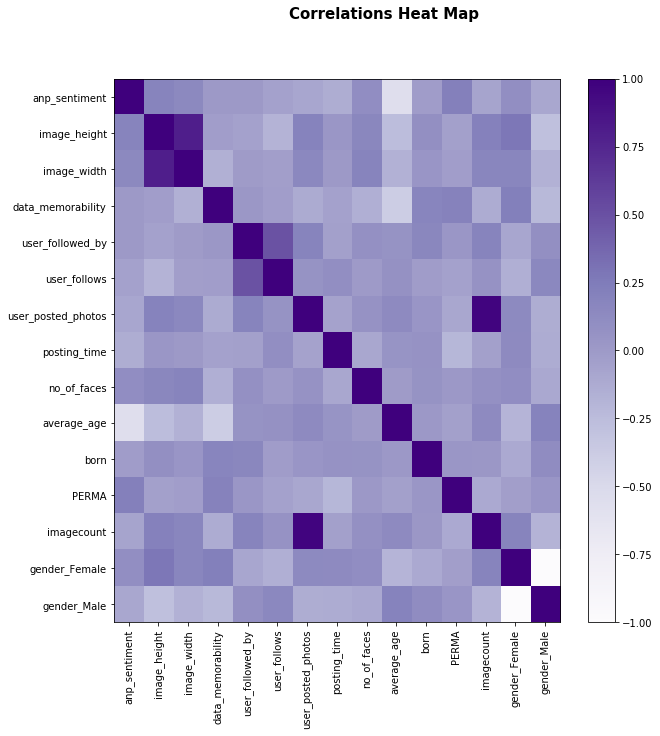

In [87]:
# Plot Correlation Matrix using Matplotlib
%pylab inline
plt.figure(figsize=(10, 10))
plt.imshow(corr, cmap='Purples', interpolation='none', aspect='auto')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns, rotation='vertical')
plt.yticks(range(len(corr)), corr.columns);
plt.suptitle('Correlations Heat Map', fontsize=15, fontweight='bold')
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a2e9048d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1a350587b8>]], dtype=object)

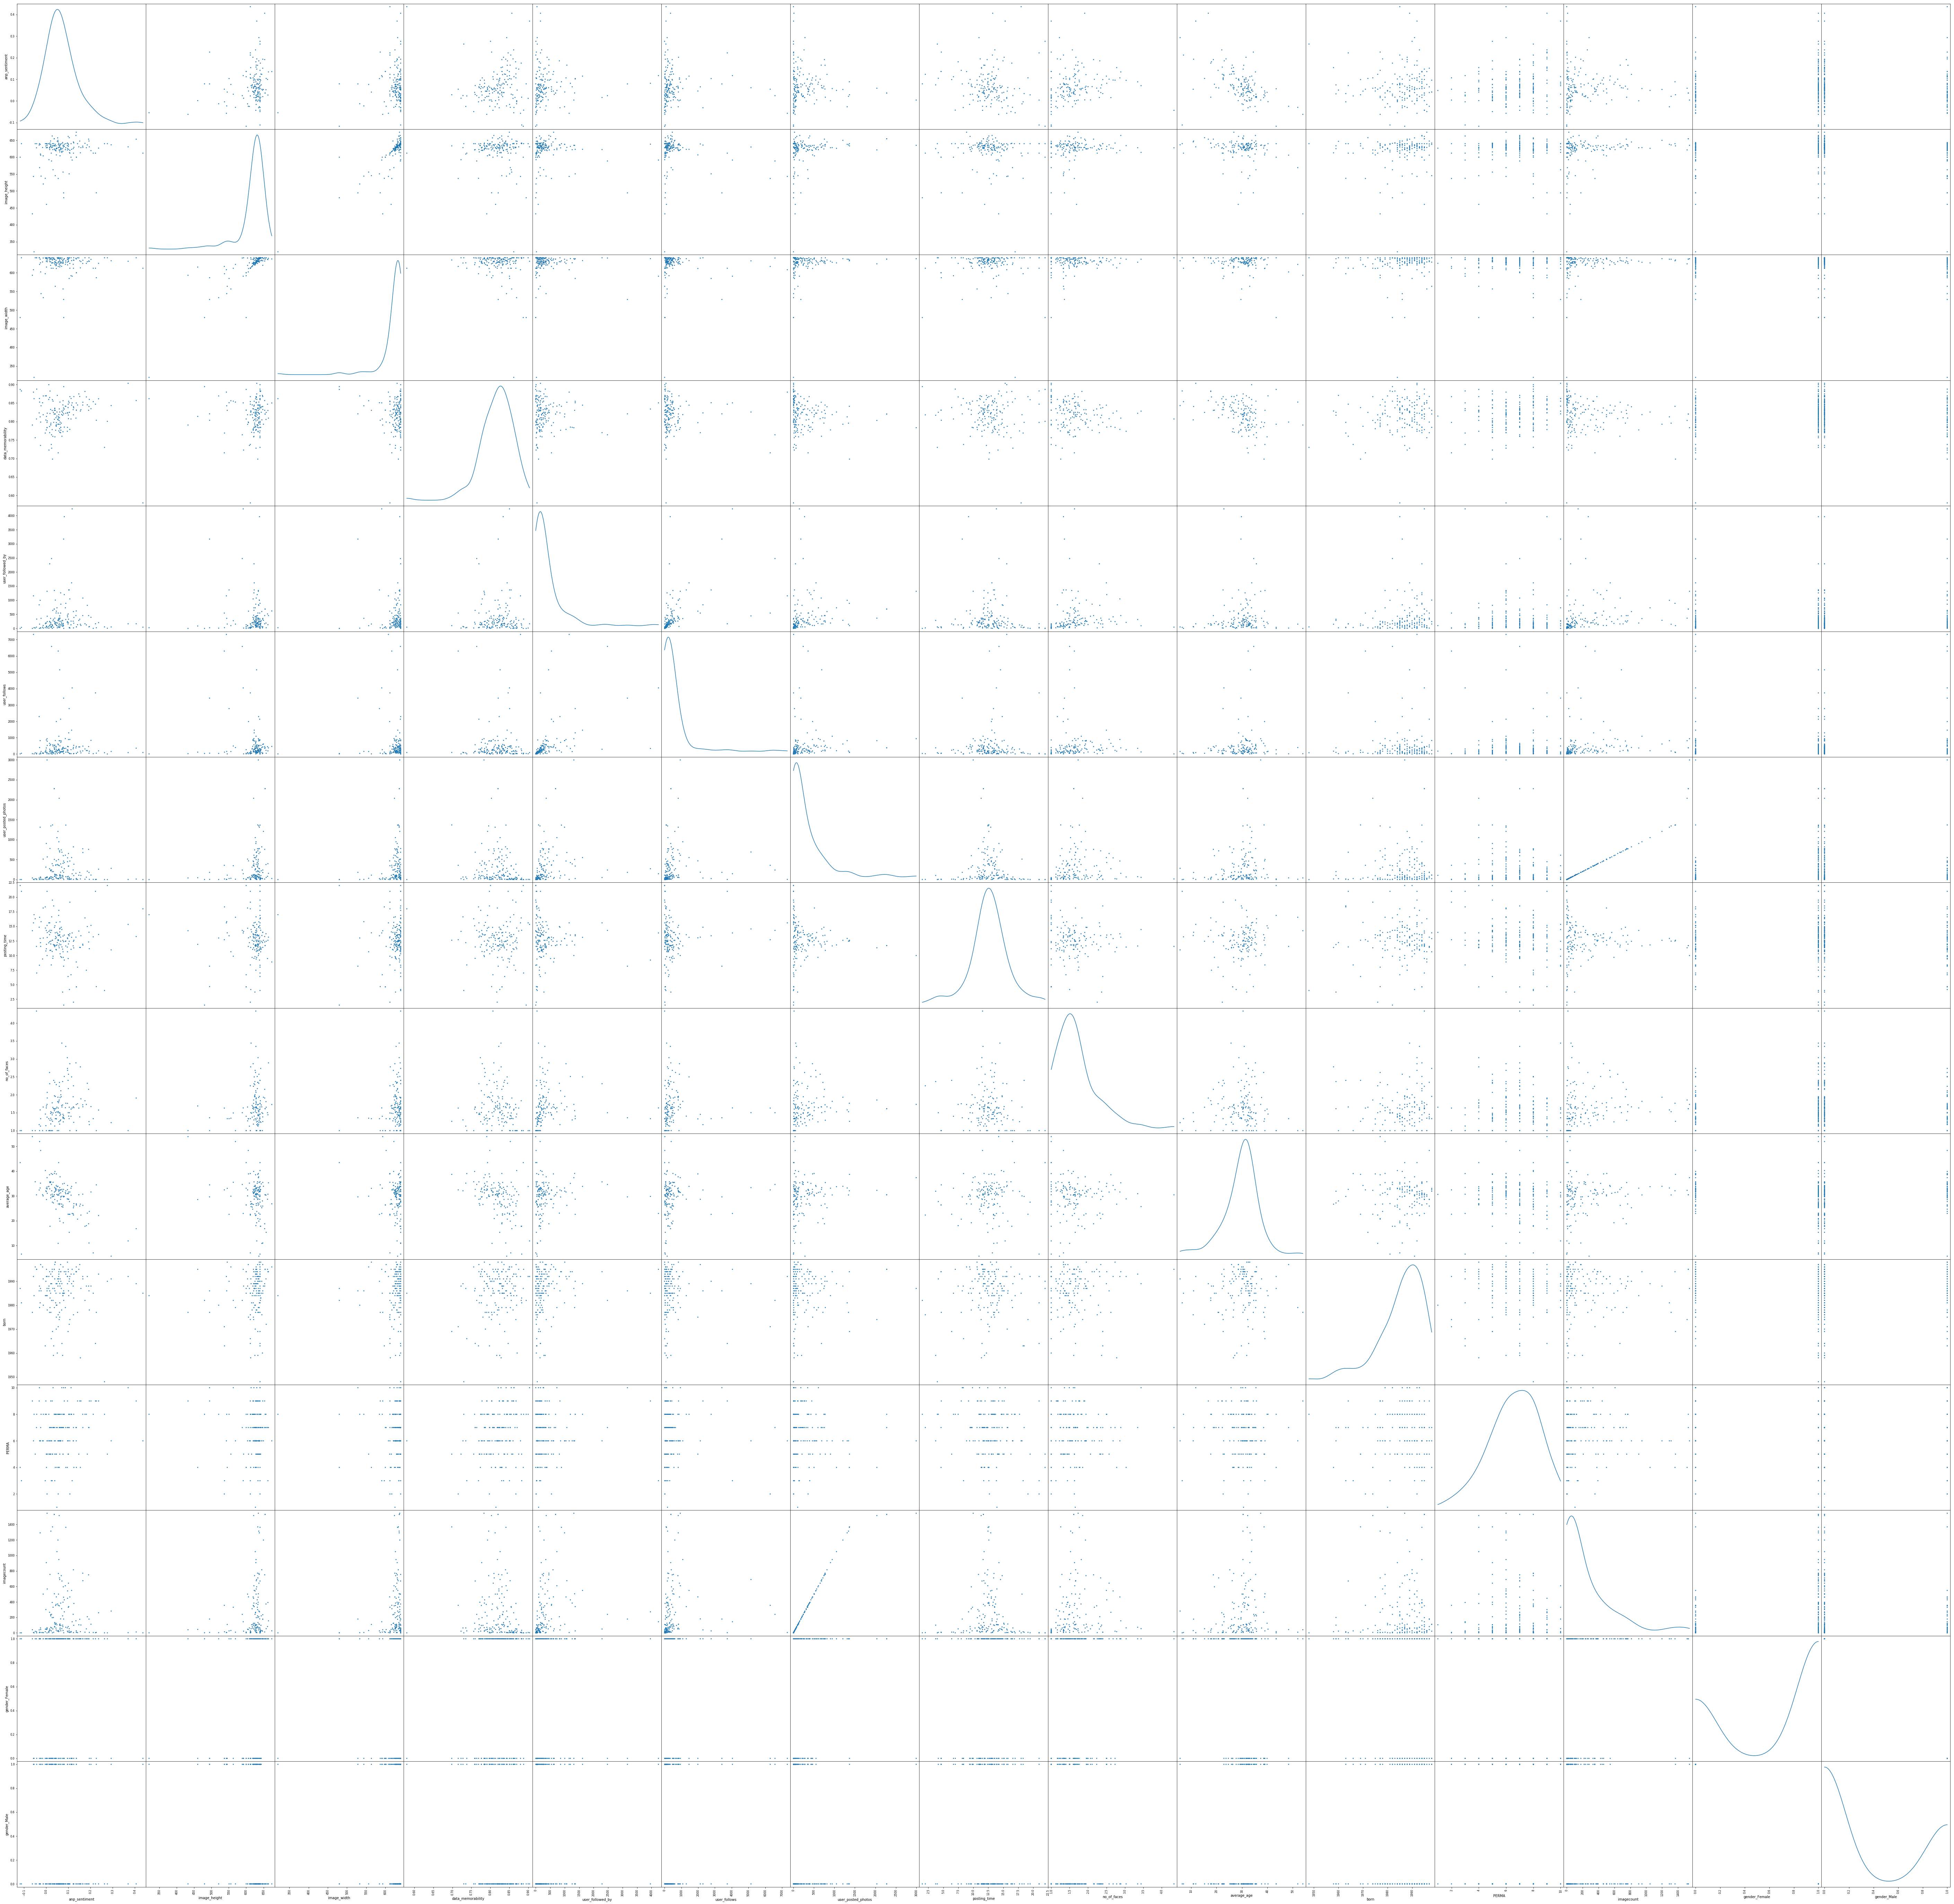

In [88]:
# Scatterplot of all variables in the dataframe
from pandas.plotting import scatter_matrix
scatter_matrix(df, alpha=1.0, figsize=(100, 100), diagonal='kde')

In [89]:
#Prepare train and test set
from sklearn.model_selection import train_test_split

X = df[['posting_time']]
y = df[['PERMA']]

# create training and testing vars
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print('X_train and y_train shape:', X_train.shape, y_train.shape)
print('X_test and y_test shape:', X_test.shape, y_test.shape)

X_train and y_train shape: (128, 1) (128, 1)
X_test and y_test shape: (33, 1) (33, 1)


In [90]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

lm = LinearRegression()
lm.fit(X_train, y_train)

y_pred = lm.predict(X_test)

# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, y_pred))

Mean squared error: 4.12
Variance score: -0.20


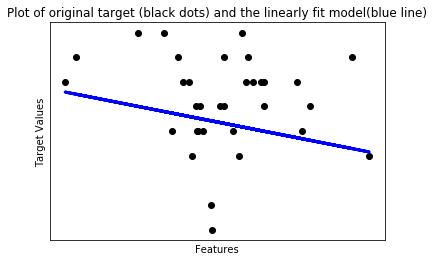

In [91]:
# Plot outputs
plt.scatter(X_test, y_test,  color='black')
plt.plot(X_test, y_pred, color='blue', linewidth=3)
plt.from sklearn import svm
clf = svm.SVC()

clf.fit(X, y) 
clf.fit(X_train, y_train)

y_pred = lm.predict(X_test)

# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, y_pred))
xlabel("Features")
plt.ylabel("Target Values")
plt.title("Plot of original target (black dots) and the linearly fit model(blue line)")

plt.xticks(())
plt.yticks(())

plt.show()